In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias.html

In [2]:
filename = 'covid19-es-and.csv'
fecha = '23/07/2021'
id_noticia = '265021'
url = 'https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias/detalle/' + id_noticia + '.html'
dias_grafico = 180

In [3]:
def DrawMediaFlotante (dfData, provincia, dias):   
    data = dfData.loc[provincia].diff().tail(dias).copy()
    data['Media Positivo 7 dias'] = data['PCR Positivo'].rolling(window=7).mean()
    data['Media Positivo 14 dias'] = data['PCR Positivo'].rolling(window=14).mean()
    titulo = 'Nuevos casos en los últimos ' + str(dias) + ' días en ' + provincia
    # print(titulo + '. (Nuevos positivos e ingresos hospitalarios)')
    data[['Hospitalización', 'PCR Positivo', 'Media Positivo 7 dias', 'Media Positivo 14 dias']].plot(
        kind='line', grid=True, figsize=(15,5), title=titulo)
    plt.xticks(
        rotation=45,    
        horizontalalignment='right',
        fontweight='light',
    )
    plt.show()
    

In [4]:
# FIX SSL: CERTIFICATE_VERIFY_FAILED with Python3
# https://stackoverflow.com/a/49174340
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
# Load
tables = pd.read_html(url, header=0, thousands='.')
assert len(tables) > 0
dfL = tables[len(tables) - 1] # Last table

In [6]:
# Prepare
dfL.columns = ['Provincia', 'PCR Positivo',	'Hospitalización', 'UCI', 'Fallecimientos',	'Curados']
dfL['Fecha'] = fecha
regex = r"(\d*\.?\d*)"

for col in ['PCR Positivo',	'Hospitalización', 'UCI', 'Fallecimientos',	'Curados']:
    # dfL[col] = dfL[col].str.extract(regex, expand=False).astype(float).fillna(0).apply(lambda x : '{0:,}'.format(x))
    dfL[col] = dfL[col].str.extract(regex, expand=False).fillna(0).apply(lambda x : str(x).replace('.', '')).astype(int)
    # .astype(float).fillna(0).apply(lambda x : '{0:,}'.format(x))
    
    # df[c] = df[c].apply(lambda x : '{0:,}'.format(x))
dfL


,Provincia,PCR Positivo,Hospitalización,UCI,Fallecimientos,Curados,Fecha
0,Almería,59118,4007,687,843,55302,23/07/2021
1,Cádiz,94686,6037,669,1512,84024,23/07/2021
2,Córdoba,62400,4840,600,980,55867,23/07/2021
3,Granada,97944,8564,1121,1797,90772,23/07/2021
4,Huelva,36643,2464,182,395,33102,23/07/2021
5,Jaén,55306,4834,456,1017,51592,23/07/2021
6,Málaga,125986,8925,839,1700,107425,23/07/2021
7,Sevilla,145905,11336,1132,2056,134914,23/07/2021
8,Total,677988,51007,5686,10300,612998,23/07/2021


In [7]:
data = pd.melt(dfL, id_vars=['Provincia', 'Fecha'])
# data.sample(5)

In [8]:
# Save to csv
data.to_csv(filename, encoding='utf-8', header=False, mode='+a', index=False)

In [9]:
# Load full csv
dfL = pd.read_csv(filename, thousands='.', parse_dates=['Fecha'], dayfirst=True)
# dfL.tail()

In [10]:
# Guardar el último día
last_fecha = dfL['Fecha'].max()

In [11]:
# Organizar en forma de tabla
df = pd.pivot_table(dfL, values='value', index=['Provincia', 'Fecha'], columns='variable')
df.sort_index(inplace=True)

In [12]:
# Variaciones con respecto al día anterior
dfV = df.groupby(level='Provincia').diff()
# dfV.tail()

In [13]:
# Para seleccionar todas las filas de una o varias fechas hay que usar un trick ya que : no se puede usar en este caso
dfG = dfV.loc[(slice(None), [last_fecha]), :]
dfG

,variable,Curados,Fallecimientos,Hospitalización,PCR Positivo,UCI
Provincia,Fecha,,,,,
Almería,2021-07-23,49.0,0.0,6.0,326.0,1.0
Cádiz,2021-07-23,223.0,0.0,5.0,814.0,1.0
Córdoba,2021-07-23,169.0,0.0,8.0,677.0,2.0
Granada,2021-07-23,245.0,3.0,13.0,416.0,0.0
Huelva,2021-07-23,80.0,0.0,3.0,291.0,0.0
Jaén,2021-07-23,142.0,0.0,3.0,331.0,0.0
Málaga,2021-07-23,586.0,2.0,41.0,1980.0,4.0
Sevilla,2021-07-23,246.0,2.0,18.0,886.0,1.0
Total,2021-07-23,1740.0,7.0,97.0,5721.0,9.0


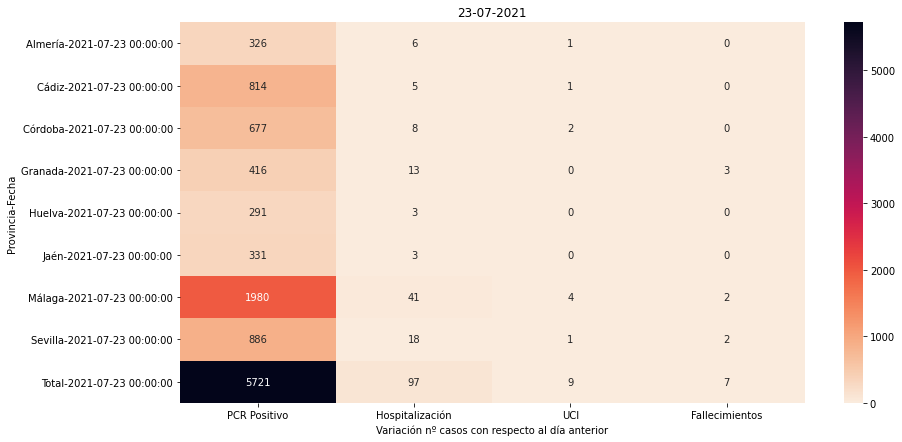

In [14]:
# Set the width and height of the figure
plt.figure(figsize=(14,7))

# Add title
plt.title(last_fecha.strftime('%d-%m-%Y'))

# Invertir los colores
cmap = sns.cm.rocket_r

# Heatmap 
sns.heatmap(data=dfG[['PCR Positivo', 'Hospitalización', 'UCI', 'Fallecimientos']], annot=True, cmap=cmap,fmt='g')

# Add label for horizontal axis
plt.xlabel('Variación nº casos con respecto al día anterior')
plt.show()

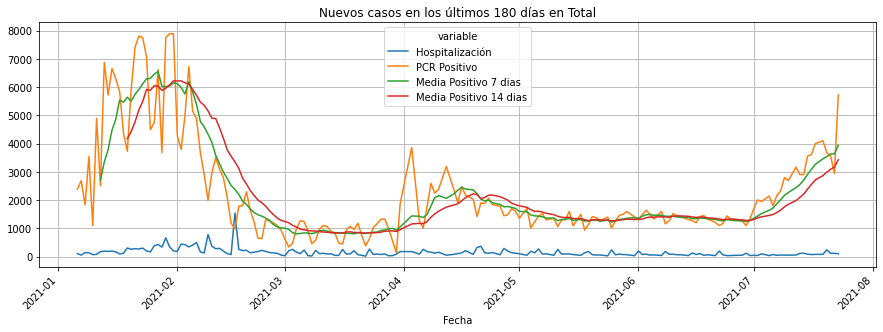

In [15]:
DrawMediaFlotante(df, 'Total', dias_grafico)

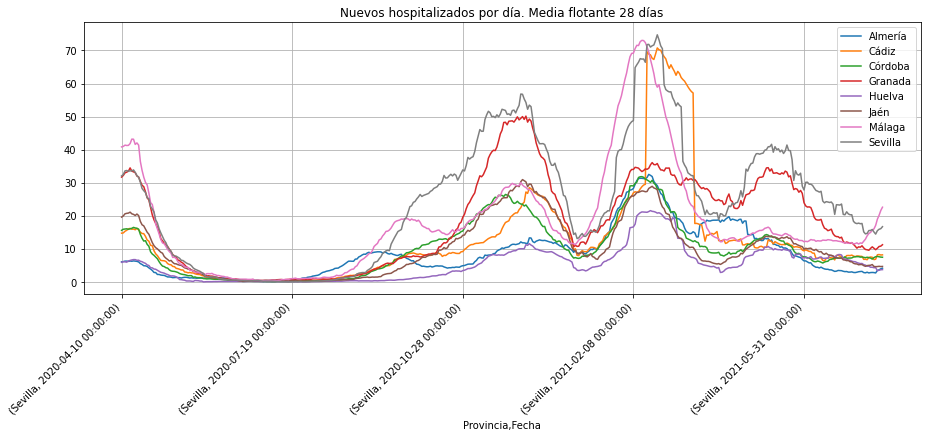

In [16]:
dias = 28
data = dfV['Hospitalización'].rolling(window=dias).mean().dropna().drop('Total')
data.groupby('Provincia').plot(title='Nuevos hospitalizados por día. Media flotante ' + str(dias) + ' días', figsize=(15,5), grid=True,legend=True)
plt.xticks(
    rotation=45,    
    horizontalalignment='right',
    fontweight='light',
)
plt.show()

In [17]:
# Fecha de último ingreso en hospital
data = df[['Hospitalización']].diff()
data = data[data['Hospitalización'] > 0].sort_index(ascending=False).groupby('Provincia').head(1).copy()
data.reset_index(inplace=True)
data['dias'] = pd.to_datetime(fecha, dayfirst=True) - data['Fecha']
data.set_index('Provincia', inplace=True)
data.sort_values(['dias', 'Hospitalización'], ascending=[False, True])

variable,Fecha,Hospitalización,dias
Provincia,,,
Jaén,2021-07-23,3.0,0 days
Huelva,2021-07-23,3.0,0 days
Cádiz,2021-07-23,5.0,0 days
Almería,2021-07-23,6.0,0 days
Córdoba,2021-07-23,8.0,0 days
Granada,2021-07-23,13.0,0 days
Sevilla,2021-07-23,18.0,0 days
Málaga,2021-07-23,41.0,0 days
Total,2021-07-23,97.0,0 days


In [18]:
# Positivos por cada Hospitalización
dfG['PCR Positivo']/dfG['Hospitalización']

Provincia  Fecha     
Almería    2021-07-23     54.333333
Cádiz      2021-07-23    162.800000
Córdoba    2021-07-23     84.625000
Granada    2021-07-23     32.000000
Huelva     2021-07-23     97.000000
Jaén       2021-07-23    110.333333
Málaga     2021-07-23     48.292683
Sevilla    2021-07-23     49.222222
Total      2021-07-23     58.979381
dtype: float64

In [19]:
# Fecha de último ingreso en UCI
data = df[['UCI']].diff()
data = data[data['UCI'] > 0].sort_index(ascending=False).groupby('Provincia').head(1).copy()
data.reset_index(inplace=True)
data['dias'] = pd.to_datetime(fecha, dayfirst=True) - data['Fecha']
data.set_index('Provincia', inplace=True)
data.sort_values(['dias', 'UCI'], ascending=[False, True])

variable,Fecha,UCI,dias
Provincia,,,
Jaén,2021-07-07,1.0,16 days
Huelva,2021-07-07,1.0,16 days
Granada,2021-07-20,3.0,3 days
Sevilla,2021-07-23,1.0,0 days
Cádiz,2021-07-23,1.0,0 days
Almería,2021-07-23,1.0,0 days
Córdoba,2021-07-23,2.0,0 days
Málaga,2021-07-23,4.0,0 days
Total,2021-07-23,9.0,0 days


In [20]:
# Fecha de último Fallecimiento
data = df[['Fallecimientos']].diff()
data = data[data['Fallecimientos'] > 0].sort_index(ascending=False).groupby('Provincia').head(1).copy()
data.reset_index(inplace=True)
data['dias'] = pd.to_datetime(fecha, dayfirst=True) - data['Fecha']
data.set_index('Provincia', inplace=True)
data.sort_values(['dias', 'Fallecimientos'], ascending=[False, True])

variable,Fecha,Fallecimientos,dias
Provincia,,,
Huelva,2021-07-02,1.0,21 days
Cádiz,2021-07-20,1.0,3 days
Córdoba,2021-07-20,2.0,3 days
Jaén,2021-07-21,2.0,2 days
Almería,2021-07-22,4.0,1 days
Sevilla,2021-07-23,2.0,0 days
Málaga,2021-07-23,2.0,0 days
Granada,2021-07-23,3.0,0 days
Total,2021-07-23,7.0,0 days


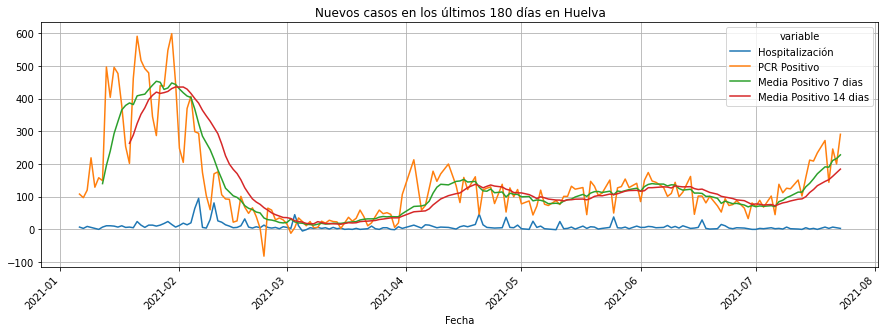

In [21]:
DrawMediaFlotante(df, 'Huelva', dias_grafico)

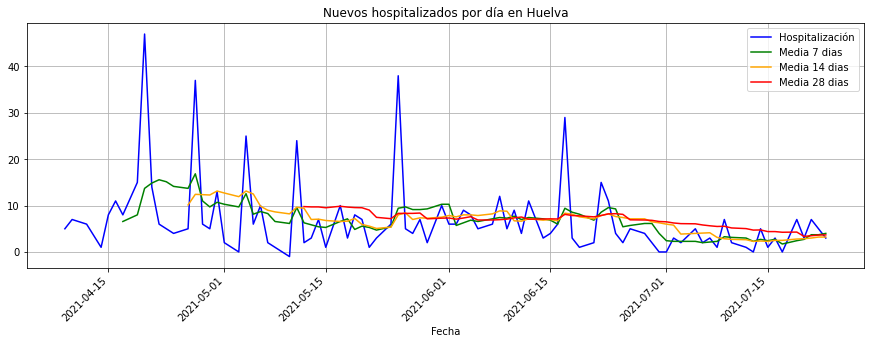

In [22]:
data = pd.DataFrame(dfV.loc['Huelva']['Hospitalización'].tail(90).copy())
data.columns = ['Hospitalización']
data['Media 7 dias'] = data['Hospitalización'].rolling(window=7).mean()
data['Media 14 dias'] = data['Hospitalización'].rolling(window=14).mean()
data['Media 28 dias'] = data['Hospitalización'].rolling(window=28).mean()
data.plot(title='Nuevos hospitalizados por día en Huelva', figsize=(15,5), grid=True, color = ['blue', 'green', 'orange', 'red'])
plt.xticks(
    rotation=45,    
    horizontalalignment='right',
    fontweight='light',
)
plt.show()

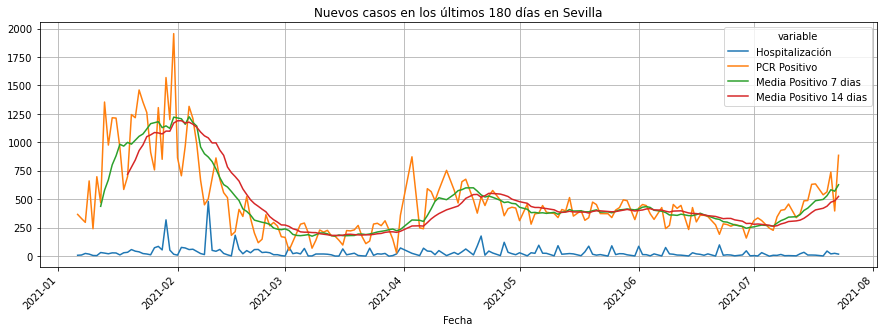

In [23]:
DrawMediaFlotante(df, 'Sevilla', dias_grafico)

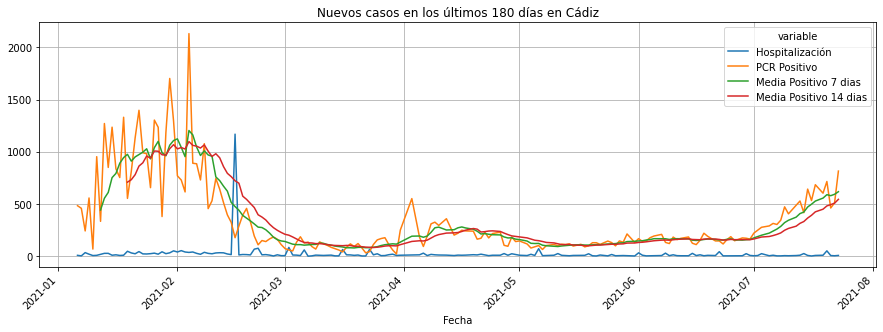

In [24]:
DrawMediaFlotante(df, 'Cádiz', dias_grafico)

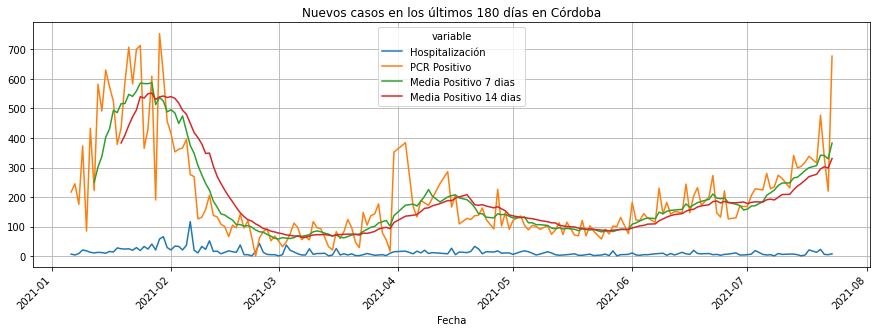

In [25]:
DrawMediaFlotante(df, 'Córdoba', dias_grafico)

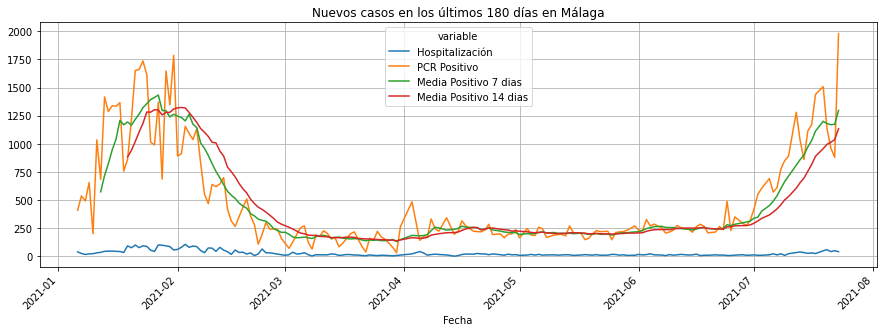

In [26]:
DrawMediaFlotante(df, 'Málaga', dias_grafico)

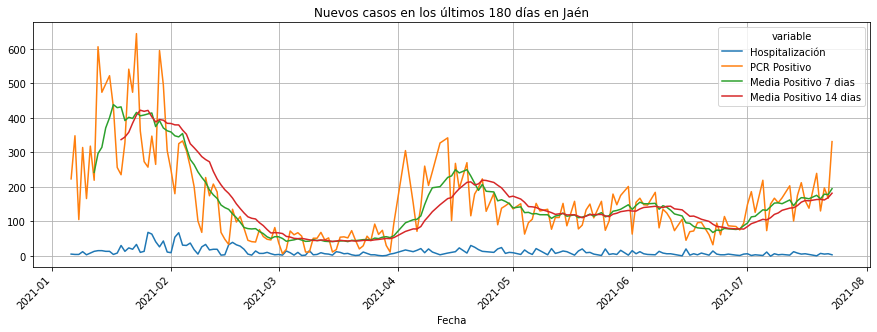

In [27]:
DrawMediaFlotante(df, 'Jaén', dias_grafico)

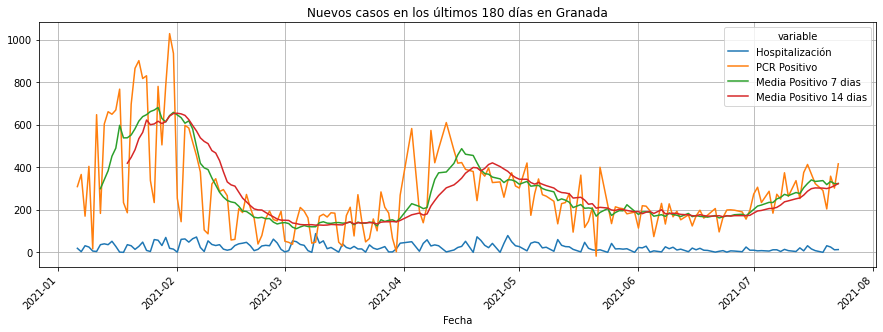

In [28]:
DrawMediaFlotante(df, 'Granada', dias_grafico)

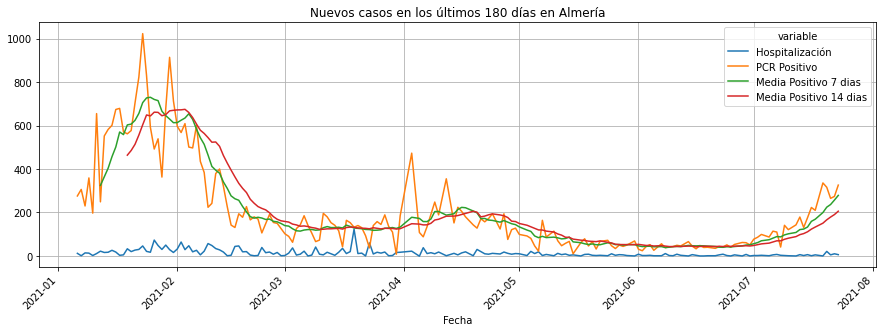

In [29]:
DrawMediaFlotante(df, 'Almería', dias_grafico)